# Introduction to Ensembling/Stacking in Python

https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python


Preparation 
---
- drive mount, install kaggle, download dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# Load in out libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold


# Using plotly in google colab notebook


https://www.youtube.com/watch?v=F2pAu9PzgEE

In [0]:
# importing and using plotly 

from IPython.display import Image
from plotly.offline import iplot # 필요없어보임

plotly 사용하는 셀 마다 이 함수 호출 시켜야함 

In [0]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"</script>
    <script>
    requirejs.config({
    paths: {
    base: '/static/base',
    plotly: 'https:..cdn.plot.ly/plotly-1.5.1.min.js?noext',
    }
    });
    </script>
    '''))


Feature Exploration, Engineering and Cleaning
---

- explore data on hand
- identify possible feature engineering
- numerically encode any caterigorical features

In [0]:
# Load in the train and test datasets

train = pd.read_csv('../content/train.csv')
test = pd.read_csv('../content/test.csv')

# Store our passenger ID for easy access

PassengerId = test['PassengerId']

train.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


feature engineering ideas from

[Titanic Best Working Classfier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier) : by Sina

In [0]:
full_data = [train, test]

# Some features fo my own that i have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a new feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)


In [0]:
# Define fucntion to extract titles from passenge names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exist, extract and return it
    if title_search:
        return title_search.group(1)
    return ""


In [0]:
# Create a new feature title, containing the title of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)    

In [0]:
# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [0]:
# Mapping sex and titles, embarked, fare
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    

Feature Selection

In [0]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis = 1)


Visualizations
---



In [0]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


Pearson Correlation Heatmap

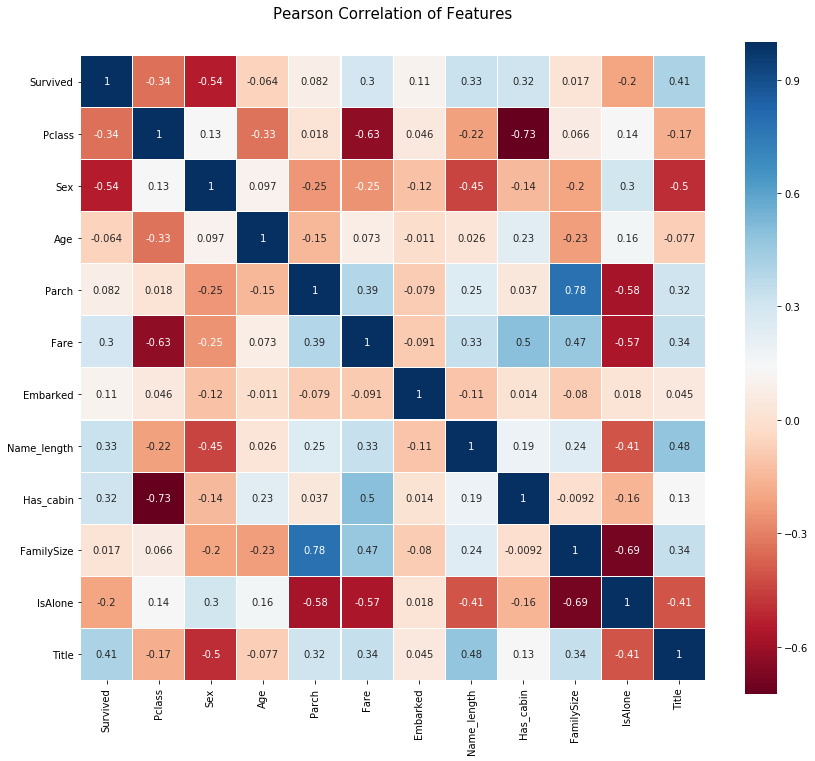

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', y= 1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)



Takeaway from the plots

대부분의 아이들이 자기들끼리 강한 상관관계를 나타내지않아 왠만하면 다 쓸 수 있음

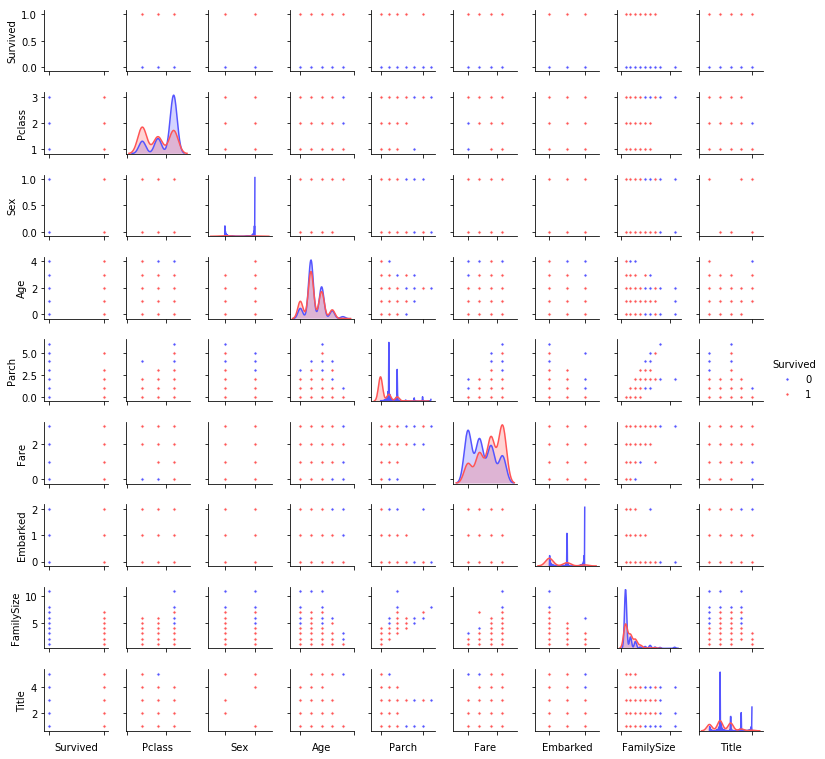

In [0]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size = 1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])


Helpers via Python Classes
---



In [0]:
# Some useful parameters which will come in handy later on 
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
# kf = KFOLD(ntrain, n_folds= NFOLDS, random_state =SEED)
kf = KFold(n_splits= NFOLDS, random_state =SEED)
kf = kf.split(np.arange(ntrain)) # change - version problem


# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
        
    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_
    
# Class to extend XGboost Classifier    


out of fold prediction

소개 섹션에서 above에 쌓아 두는 입력으로 2단계 모델 연습을 위해 기지 classifiers의 예측을 사용하여 언급했다. 하지만 사람 단순히 전체 훈련 데이터에 보름 시험에 예측을 만들고 이급 훈련을 위해 이 출력한 기본 모델을 훈련시킬 수 없다. 이것은 당신의 베이스 모형 예측 이미" 보"시험 세트와 이에 따라 이러한 예고들에게 먹이를 주고 overfitting는 것의 위험이 따른다

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
    

# Generating our Base First-Level Models


Random Forest/
Extra Trees/
AdaBoost/
Gradient Boosting/
Support Vector Machine



Parameters

Just a quick summary of the parameters that we will be listing here for completeness,

n_jobs : Number of cores used for the training process. If set to -1, all cores are used.

n_estimators : Number of classification trees in your learning model ( set to 10 per default)

max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

In [0]:
# Put in our parameters for said classifiers
# Random Forest parameters

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
#     'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
#     'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Adaboost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters

gb_params = {
    'n_estimators': 500,
#     'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}


In [0]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)



Creating NumPy arrays out of our train and test sets

In [0]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models

y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis = 1)
x_train = train.values # creates an array of the train data
x_test = test.values # creates an array of the test dataset

Output of the First level predictions

5개의 분류기에 out of fold prediction funcction 사용할것. 첫 단계 예측 

In [0]:
# Creat of OOF train and test predictions. These base results will be used as new features

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print('Training is complete')

Training is complete


In [0]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)


In [0]:
cols = train.columns.values

# Create a dataframe with features

feature_df = pd.DataFrame({'features': cols,
                          'Random Forest feature importances': rf_feature,
                          'Extra Trees feature importances': et_feature,
                          'AdaBoost feature importances': ada_feature,
                          'Gradient Boosting feature importances': gb_feature})

Interactive feature importances via Plotly scatterplots

In [0]:
# Scater plot
configure_plotly_browser_state()
py.init_notebook_mode(connected=True)
trace = go.Scatter(y= feature_df['Random Forest feature importances'].values,
                  x= feature_df['features'].values,
                  mode = 'markers',
                  marker = dict(sizemode = 'diameter',
                               sizeref = 1,
                               size = 25,
#                                size = feature_df['AdaBoost feature importances'].values,
#                                color = np,random.randn(500), # Set color equal to a variable
                               color = feature_df['Random Forest feature importances'].values,
                               colorscale='Portland',
                               showscale=True),
                  text = feature_df['features'].values)
data = [trace]

layout = go.Layout(autosize= True,
                  title = 'Random Forest Feature Importance',
                  hovermode = 'closest',
#                   xaxis = dict(title = 'Pop',
#                               ticklen = 5,
#                               zeroline = False,
#                               gridwith =2,)
                  yaxis = dict(title = 'Feature Importance',
                               ticklen = 5,
                               gridwidth = 2),
                  showlegend=False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')


In [0]:
# Scater plot
configure_plotly_browser_state()
py.init_notebook_mode(connected=True)
trace = go.Scatter(y= feature_df['Extra Trees feature importances'].values,
                  x= feature_df['features'].values,
                  mode = 'markers',
                  marker = dict(sizemode = 'diameter',
                               sizeref = 1,
                               size = 25,
#                                size = feature_df['AdaBoost feature importances'].values,
#                                color = np,random.randn(500), # Set color equal to a variable
                               color = feature_df['Extra Trees feature importances'].values,
                               colorscale='Portland',
                               showscale=True),
                  text = feature_df['features'].values)
data = [trace]

layout = go.Layout(autosize= True,
                  title = 'Extra Trees Feature Importance',
                  hovermode = 'closest',
#                   xaxis = dict(title = 'Pop',
#                               ticklen = 5,
#                               zeroline = False,
#                               gridwith =2,)
                  yaxis = dict(title = 'Feature Importance',
                               ticklen = 5,
                               gridwidth = 2),
                  showlegend=False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')


In [0]:
# Adaboost Scater plot
configure_plotly_browser_state()
py.init_notebook_mode(connected=True)
trace = go.Scatter(y= feature_df['AdaBoost feature importances'].values,
                  x= feature_df['features'].values,
                  mode = 'markers',
                  marker = dict(sizemode = 'diameter',
                               sizeref = 1,
                               size = 25,
#                                size = feature_df['AdaBoost feature importances'].values,
#                                color = np,random.randn(500), # Set color equal to a variable
                               color = feature_df['AdaBoost feature importances'].values,
                               colorscale='Portland',
                               showscale=True),
                  text = feature_df['features'].values)
data = [trace]

layout = go.Layout(autosize= True,
                  title = 'AdaBoost Feature Importance',
                  hovermode = 'closest',
#                   xaxis = dict(title = 'Pop',
#                               ticklen = 5,
#                               zeroline = False,
#                               gridwith =2,)
                  yaxis = dict(title = 'Feature Importance',
                               ticklen = 5,
                               gridwidth = 2),
                  showlegend=False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')


In [0]:
# Scater plot
configure_plotly_browser_state()
py.init_notebook_mode(connected=True)
trace = go.Scatter(y= feature_df['Gradient Boosting feature importances'].values,
                  x= feature_df['features'].values,
                  mode = 'markers',
                  marker = dict(sizemode = 'diameter',
                               sizeref = 1,
                               size = 25,
#                                size = feature_df['AdaBoost feature importances'].values,
#                                color = np,random.randn(500), # Set color equal to a variable
                               color = feature_df['Gradient Boosting feature importances'].values,
                               colorscale='Portland',
                               showscale=True),
                  text = feature_df['features'].values)
data = [trace]

layout = go.Layout(autosize= True,
                  title = 'Gradient Boosting Feature Importance',
                  hovermode = 'closest',
#                   xaxis = dict(title = 'Pop',
#                               ticklen = 5,
#                               zeroline = False,
#                               gridwith =2,)
                  yaxis = dict(title = 'Feature Importance',
                               ticklen = 5,
                               gridwidth = 2),
                  showlegend=False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')


caculate the mean of all the feature importances and store it as a new column in the feature importance df.

In [0]:
# Create the new col containing the average of values

feature_df['mean'] = feature_df.mean(axis = 1) # axis 1 computes the mean row wise
feature_df.head(3)


,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boosting feature importances,mean
0,Pclass,0.110683,0.119754,0.030,0.084357,0.086198
1,Sex,0.237787,0.381154,0.012,0.009481,0.160106
2,Age,0.037586,0.031628,0.014,0.056972,0.035047



Plotly Barplot of Average Feature Importances
---



In [0]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=True)

y = feature_df['mean'].values
x = feature_df['features'].values
data = [go.Bar(x=x,
              y=y,
              width = 0.5,
              marker = dict(color = feature_df['mean'].values,
                           colorscale='Portland',
                           showscale= True,
                           reversescale=False),
               opacity = 0.6
              )]

layout = go.Layout(autosize = True,
                  title = 'Barplots of Mean Feature Importance',
                  hovermode = 'closest',
                  #                   xaxis = dict(title = 'Pop',
#                               ticklen = 5,
#                               zeroline = False,
#                               gridwith =2,)
                  yaxis = dict(title = 'Feature Importance',
                               ticklen = 5,
                               gridwidth = 2),
                  showlegend=False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'bar-direct-labels')


# Second-Level Predictions from the First-level output

First level output as new features

In [0]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                      'ExtraTrees': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'GradientBoost': gb_oof_train.ravel()})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [0]:
configure_plotly_browser_state()
py.init_notebook_mode(connected=True)

data = [go.Heatmap(z= base_predictions_train.astype(float).corr().values,
                  x = base_predictions_train.columns.values,
                  y = base_predictions_train.columns.values,
                  colorscale = 'Viridis',
                  showscale = True,
                  reversescale = True)]

py.iplot(data, filename = 'labelled-heatmap')

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [0]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis = 1)

In [0]:
x_train

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])


Second Level learning model via XGBoost
---



In [0]:
gbm = xgb.XGBClassifier(n_estimators = 2000,
#                        learning_rate = 0.02,
                        max_depth=4,
                        min_child_weight = 2,
#                         gamma =1,
                        subsample = 0.8,
                        colsample_bytree = 0.8,
                        objective = 'binary:logistic',
                        nthread = -1,
                        scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)  

Producing the submission file

In [0]:
# Generate Submission file

StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                                  'Survived': predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)